##### Copyright 2020 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Chapter 10 - Big Entropy and The Generalized Linear Model

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/statistical_rethinking/notebooks/10_big_entropy_and_the_generalized_linear_model"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/statistical_rethinking/notebooks/10_big_entropy_and_the_generalized_linear_model.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/statistical_rethinking/notebooks/10_big_entropy_and_the_generalized_linear_model.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/examples/statistical_rethinking/notebooks/10_big_entropy_and_the_generalized_linear_model.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Imports and utility functions


In [2]:
#@title Install { display-mode: "form" }
TF_Installation = 'System' #@param ['TF Nightly', 'TF Stable', 'System']

if TF_Installation == 'TF Nightly':
  !pip install -q --upgrade tf-nightly
  print('Installation of `tf-nightly` complete.')
elif TF_Installation == 'TF Stable':
  !pip install -q --upgrade tensorflow
  print('Installation of `tensorflow` complete.')
elif TF_Installation == 'System':
  pass
else:
  raise ValueError('Selection Error: Please select a valid '
                   'installation option.')

In [3]:
#@title Install { display-mode: "form" }
TFP_Installation = "System" #@param ["Nightly", "Stable", "System"]

if TFP_Installation == "Nightly":
  !pip install -q tfp-nightly
  print("Installation of `tfp-nightly` complete.")
elif TFP_Installation == "Stable":
  !pip install -q --upgrade tensorflow-probability
  print("Installation of `tensorflow-probability` complete.")
elif TFP_Installation == "System":
  pass
else:
  raise ValueError("Selection Error: Please select a valid "
                   "installation option.")

In [4]:
#@title Install { display-mode: "form" }

# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    print("Installing arviz ...")
    !pip install -q arviz

In [5]:
# Core
import numpy as np
import arviz as az
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions

# Introduction

## 10.1 Maximum entropy

##### Code 10.1

In [6]:
d = {'A':[0, 0, 10, 0, 0], 
     'B':[0, 1, 8, 1, 0], 
     'C':[0, 2, 6, 2, 0], 
     'D':[1, 2, 4, 2, 1], 
     'E':[2, 2, 2, 2, 2]}
p = pd.DataFrame(data=d)

##### Code 10.2

In [7]:
p_norm = p/p.sum(0)

##### Code 10.3

In [8]:

def entropy(x):
    y = []
    for i in x:
        if i == 0:
            y.append(0)
        else: 
            y.append(i*np.log(i))
    h = -sum(y)
    return h
H = p_norm.apply(entropy, axis=0)
H

A   -0.000000
B    0.639032
C    0.950271
D    1.470808
E    1.609438
dtype: float64

##### Code 10.4

In [9]:
ways = np.array([1, 90, 1260, 37800, 113400])
logwayspp = np.log(ways) / 10

### 10.1.2 Binomial

##### Code 10.5

In [10]:
# Build list of the candidate distributions.
p = [[1/4, 1/4, 1/4, 1/4],
     [2/6, 1/6, 1/6, 2/6],
     [1/6, 2/6, 2/6, 1/6],
     [1/8, 4/8, 2/8, 1/8]]

# Compute expected value of each. The sum of the multiplied entries is just a dot product.
p_ev = [np.dot(i, [0, 1, 1, 2]) for i in p]
p_ev

[1.0, 1.0, 1.0, 1.0]

##### Code 10.6

In [11]:

# Compute entropy of each distribution
p_ent = [entropy(i) for i in p]
p_ent

[1.3862943611198906,
 1.3296613488547582,
 1.3296613488547582,
 1.2130075659799042]

##### Code 10.7

In [12]:
p = 0.7
A = [(1-p)**2, p*(1-p), (1-p)*p, p**2]
A

[0.09000000000000002,
 0.21000000000000002,
 0.21000000000000002,
 0.48999999999999994]

##### Code 10.8

In [13]:
-np.sum(A*np.log(A))

1.221728604109787

##### Code 10.9

In [14]:
def sim_p(G=1.4):
    x123 = tfd.Uniform(low=0., high=1.).sample(3).numpy()
    x4 = (G * np.sum(x123) - x123[1] - x123[2]) / (2 - G)
    x1234 = np.concatenate((x123, [x4]))
    z = np.sum(x1234)
    p = x1234 / z
    return - np.sum(p * np.log(p)), p

##### Code 10.10

In [15]:
# should re-write this using map
H = []
p = np.zeros((10**5, 4))

for rep in range(10**5):
    h, p_ = sim_p()
    H.append(h)
    p[rep] = p_

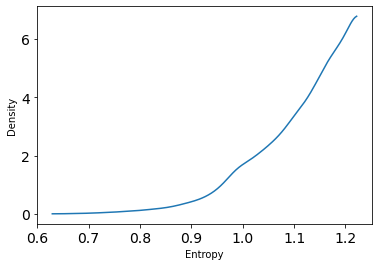

In [16]:
az.plot_kde(H)
plt.xlabel('Entropy')
plt.ylabel('Density');

##### Code 10.11

In [17]:
entropies = H
distributions = p

##### Code 10.12

In [18]:
np.max(H)

1.2217284962983819

##### Code 10.13

In [19]:
p[np.argmax(H)]

array([0.089919  , 0.21009819, 0.21006378, 0.48991903])